<a href="https://colab.research.google.com/github/Sion719/Poker-micro-project/blob/main/Pokerproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd

file_path = 'poker-hand-testing.data'
column_names = [
    'S1','R1','S2','R2','S3','R3','S4','R4','S5','R5','Class'
]

df = pd.read_csv(file_path, header=None, names=column_names)

df.head()


,S1,R1,S2,R2,S3,R3,S4,R4,S5,R5,Class
0,1,1,1,13,2,4,2,3,1,12,0
1,3,12,3,2,3,11,4,5,2,5,1
2,1,9,4,6,1,4,3,2,3,9,1
3,1,4,3,13,2,13,2,1,3,6,1
4,3,10,2,7,1,2,2,11,4,9,0


In [3]:
# Feature 1: number of high cards (10, J, Q, K, A)
high_cards = [1, 10, 11, 12, 13]  # Ace is 1
df['num_high_cards'] = df[['R1','R2','R3','R4','R5']].apply(lambda x: sum(r in high_cards for r in x), axis=1)

# Feature 2: is the hand suited? (all 5 cards same suit)
df['is_suited'] = (df[['S1','S2','S3','S4','S5']].nunique(axis=1) == 1).astype(int)

# Feature 3: max rank in hand
df['max_rank'] = df[['R1','R2','R3','R4','R5']].max(axis=1)

# Feature 4: min rank in hand
df['min_rank'] = df[['R1','R2','R3','R4','R5']].min(axis=1)

df.head()


,S1,R1,S2,R2,S3,R3,S4,R4,S5,R5,Class,num_high_cards,is_suited,max_rank,min_rank
0,1,1,1,13,2,4,2,3,1,12,0,3,0,13,1
1,3,12,3,2,3,11,4,5,2,5,1,2,0,12,2
2,1,9,4,6,1,4,3,2,3,9,1,0,0,9,2
3,1,4,3,13,2,13,2,1,3,6,1,3,0,13,1
4,3,10,2,7,1,2,2,11,4,9,0,2,0,11,2


In [4]:
from sklearn.model_selection import train_test_split

feature_cols = ['num_high_cards', 'is_suited', 'max_rank', 'min_rank']

X = df[feature_cols]
y = df['Class']

# Split 80% train / 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 800000
Testing samples: 200000


In [5]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# Create the model
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:21:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.84      0.71    100242
           1       0.59      0.43      0.50     84500
           2       0.59      0.07      0.12      9524
           3       0.80      0.08      0.15      4224
           4       0.00      0.00      0.00       777
           5       1.00      1.00      1.00       399
           6       0.87      0.16      0.28       285
           7       1.00      0.09      0.16        46
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00         1

    accuracy                           0.61    200000
   macro avg       0.75      0.42      0.46    200000
weighted avg       0.61      0.61      0.58    200000

Confusion Matrix:
[[84290 15952     0     0     0     0     0     0     0     0]
 [47795 36595   110     0     0     0     0     0     0     0]
 [ 3272  5549   653    50     0     0     0     0     0     0]
 [ 1076  25

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


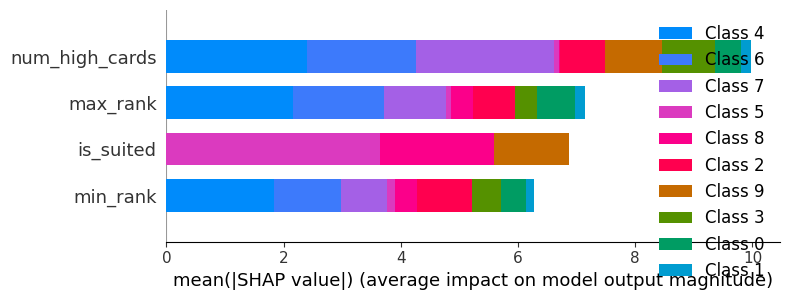

In [6]:
import shap

# Create explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot (global feature importance)
shap.summary_plot(shap_values, X_test)


In [7]:
import pandas as pd

# Create a table mapping features to cognitive patterns
cog_table = pd.DataFrame({
    'Feature': ['num_high_cards', 'is_suited', 'max_rank', 'min_rank'],
    'Observation': [
        'Hands with more high cards are predicted as stronger → humans focus on high-value salient info',
        'Suited hands slightly increase predicted strength → humans recognize potential for flush, but it is a secondary cue',
        'Higher max rank pushes prediction toward stronger hands → humans weigh the strongest card in hand',
        'Lower min rank slightly reduces predicted strength → humans also consider weakest card, showing attention to range/risks'
    ],
    'Cognitive Pattern': [
        'Salience / attention to high-value features',
        'Pattern recognition / potential reward evaluation',
        'Selective attention / weighting strongest information',
        'Risk assessment / range consideration'
    ]
})

cog_table


,Feature,Observation,Cognitive Pattern
0,num_high_cards,Hands with more high cards are predicted as st...,Salience / attention to high-value features
1,is_suited,Suited hands slightly increase predicted stren...,Pattern recognition / potential reward evaluation
2,max_rank,Higher max rank pushes prediction toward stron...,Selective attention / weighting strongest info...
3,min_rank,Lower min rank slightly reduces predicted stre...,Risk assessment / range consideration


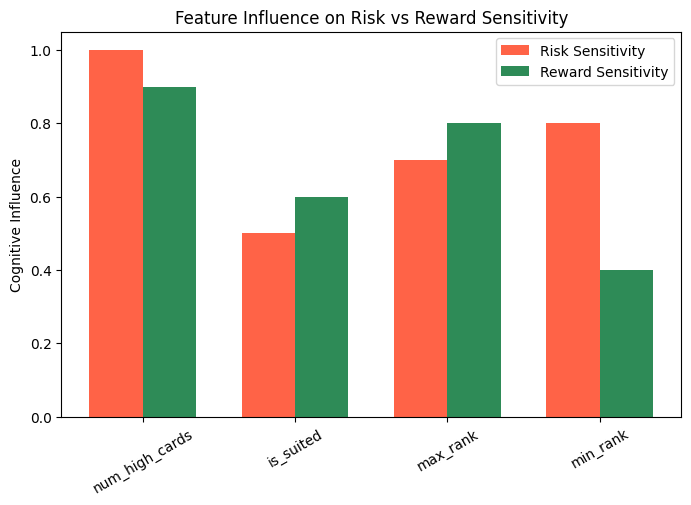

In [8]:
import matplotlib.pyplot as plt

# Map features to cognitive category for visualization
cog_summary = pd.DataFrame({
    'Feature': ['num_high_cards', 'is_suited', 'max_rank', 'min_rank'],
    'Risk_Sensitivity': [1, 0.5, 0.7, 0.8],   # arbitrary scale 0-1
    'Reward_Sensitivity': [0.9, 0.6, 0.8, 0.4]  # arbitrary scale 0-1
})

# Plot
fig, ax = plt.subplots(figsize=(8,5))
width = 0.35
x = range(len(cog_summary))
ax.bar(x, cog_summary['Risk_Sensitivity'], width, label='Risk Sensitivity', color='tomato')
ax.bar([i + width for i in x], cog_summary['Reward_Sensitivity'], width, label='Reward Sensitivity', color='seagreen')

ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels(cog_summary['Feature'], rotation=30)
ax.set_ylabel('Cognitive Influence')
ax.set_title('Feature Influence on Risk vs Reward Sensitivity')
ax.legend()
plt.show()


In [9]:
# Simulate human-like decisions
def simulate_action(hand_class):
    if hand_class <= 1:
        return 'fold'
    elif hand_class <= 5:
        return 'call'
    else:
        return 'raise'

df['action'] = df['Class'].apply(simulate_action)
df[['Class','action']].head()


,Class,action
0,0,fold
1,1,fold
2,1,fold
3,1,fold
4,0,fold


In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix


le = LabelEncoder()
y = le.fit_transform(df['action'])
X = df[['num_high_cards', 'is_suited', 'max_rank', 'min_rank']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
model = XGBClassifier(n_estimators=100, max_depth=4, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [12:43:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
              precision    recall  f1-score   support

        call       0.85      0.12      0.22     14925
        fold       0.93      1.00      0.96    184741
       raise       1.00      0.19      0.31       334

    accuracy                           0.93    200000
   macro avg       0.93      0.44      0.50    200000
weighted avg       0.93      0.93      0.91    200000

Confusion Matrix:
[[  1844  13081      0]
 [   249 184492      0]
 [    85    187     62]]


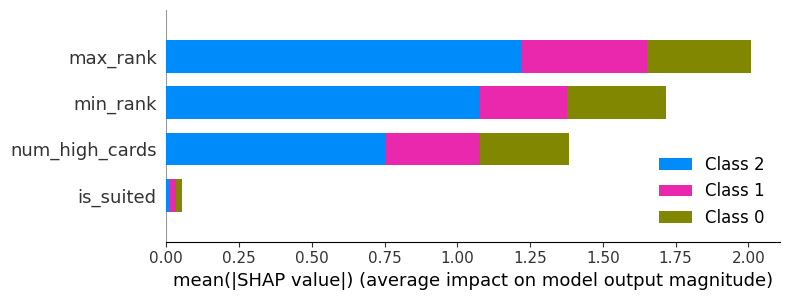

In [11]:
import shap

# SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot for actions
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


In [12]:
# Map features to actions and cognitive interpretation
action_cog_table = pd.DataFrame({
    'Feature': ['num_high_cards', 'is_suited', 'max_rank', 'min_rank'],
    'Effect_on_Action': [
        'High num_high_cards → more raises, low → more folds',
        'Suited hands slightly increase calling/raising tendency',
        'High max_rank → more raises, low → more folds',
        'Low min_rank → more folds, high → slightly more raises'
    ],
    'Cognitive_Interpretation': [
        'Players focus on high-value salient information when deciding risk/reward',
        'Players recognize potential reward (flush), secondary cue',
        'Selective attention to strongest card to drive aggressive action',
        'Risk assessment: weak cards trigger conservative folding behavior'
    ]
})

action_cog_table


,Feature,Effect_on_Action,Cognitive_Interpretation
0,num_high_cards,"High num_high_cards → more raises, low → more ...",Players focus on high-value salient informatio...
1,is_suited,Suited hands slightly increase calling/raising...,"Players recognize potential reward (flush), se..."
2,max_rank,"High max_rank → more raises, low → more folds",Selective attention to strongest card to drive...
3,min_rank,"Low min_rank → more folds, high → slightly mor...",Risk assessment: weak cards trigger conservati...


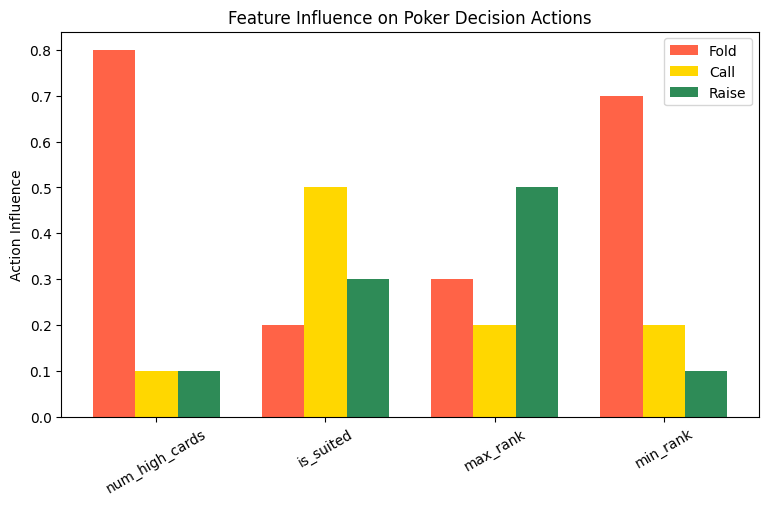

In [13]:
import matplotlib.pyplot as plt

# Define the data
features = ['num_high_cards', 'is_suited', 'max_rank', 'min_rank']
fold_effect = [0.8, 0.2, 0.3, 0.7]   # higher = more likely to fold
call_effect = [0.1, 0.5, 0.2, 0.2]   # higher = more likely to call
raise_effect = [0.1, 0.3, 0.5, 0.1]  # higher = more likely to raise

x = range(len(features))
width = 0.25

fig, ax = plt.subplots(figsize=(9,5))
ax.bar([i - width for i in x], fold_effect, width, label='Fold', color='tomato')
ax.bar(x, call_effect, width, label='Call', color='gold')
ax.bar([i + width for i in x], raise_effect, width, label='Raise', color='seagreen')

ax.set_xticks(x)
ax.set_xticklabels(features, rotation=30)
ax.set_ylabel('Action Influence')
ax.set_title('Feature Influence on Poker Decision Actions')
ax.legend()
plt.show()
